# Mustachify Notebook

In [197]:
from PIL import Image, ImageDraw
from face_recognition import face_landmarks
import numpy as np

## Model Parameters

In [198]:
imgPath = "images/worldleaders.jpg"
stickerPath = "images/mustache.png"
modelsize = "small"
rotation = True
perspective = True   
showLandmarks = False # for testing

  ## Quadrilitarel Functions
are used to shape the quadrilitarel that is used for the four-point perspective transformation of the sticker. The quadriliteral is shaped as perfect as possible so that the image itself is least transformed to prevent quality-loss.

In [199]:
def findCoefficients(a, b):
    """
    find coefficientes (so)
    """
    matrix = []
    for p1, p2 in zip(a, b):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = np.matrix(matrix, dtype=np.float)
    B = np.array(b).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)


def midPoint(a, b, ratio):
    """
    returns the point in between a and b at a distance of ratio*(b-a)

    :param a: point to start the walk
    :param b: point to walk to
    :return: point between a and b, when you walked :ratio: part of total
    """
    ax, ay = a
    bx, by = b
    dx = (bx-ax)*ratio
    dy = (by-ay)*ratio
    return ax+dx, ay+dy


def quadMove(quad, xy=(0,0)):
    """
    Moves the quad's position to the given xy position

    :param quad:
    :param xy:
    :return: quad at minimal position xy 
    """
    xmin, ymin = [min(a) for a in zip(*quad)]
    xmin, ymin = xmin+xy[0], ymin+xy[1]
    return [(x-xmin, y-ymin) for x, y in quad]


def quadRotate(quad, degrees=None):
    """

    """
    if degrees == None:
        dy = quad[1][1] - quad[0][1]
    else:
        ratio = np.tan(np.deg2rad(degrees))
        x = quad[1][0] - quad[0][0]
        dy = x/ratio
 
    return [quad[0], (quad[1][0], quad[1][1]-dy), quad[2], (quad[3][0], quad[3][1]-dy)]

def landmark2quad(landmark, move=True, scale=6):
    """
    Find convenient quadrilateral from 5 landmark points for transformation of mask
    The ratios are based on a perfect frontal face.
    This function can be used for 5 or 68 landmarkpoint by small and large model of the face_landmarks() function

    :param landmark: landmark points based on small or large model from face_recognition
    :param move: if True, the smalles xy values are 0. If xy coordinates are given, the smalles xy values will be those coordinates
    :return: 4 xy tuples with corner values of quadrilateral [top_left, top_right, botton_left, bottom_right]
    """
    if len(landmark) == 3:  # model="small"
        lEyeOut, lEyeIn = landmark["left_eye"]
        rEyeOut, rEyeIn = landmark["right_eye"]
        noseTip = landmark["nose_tip"][0]
    elif len(landmark) == 9: # model="large"
        lEyeOut = landmark["left_eye"][0]
        lEyeIn = landmark["left_eye"][3]
        rEyeOut = landmark["right_eye"][3]
        rEyeIn = landmark["right_eye"][0]
        noseTip = landmark["nose_tip"][2]
    else:
        raise ValueError("Doesn't recognize landmarks; len(nose_tip) should be 1 or 5")
    topLeft     = midPoint(a=lEyeOut, b=lEyeIn,  ratio=0.52)#0.31)
    topRight    = midPoint(a=rEyeOut, b=rEyeIn,  ratio=0.52)
    bottomLeft  = midPoint(a=lEyeOut, b=noseTip, ratio=0.31)#0.18
    bottomRight = midPoint(a=rEyeOut, b=noseTip, ratio=0.31)
    quad = [topLeft, topRight, bottomLeft, bottomRight]
    
    # normalize quadrilateral to (0,0) or give xy tuple/list
    # if move==True:
    #     return quadMove(quad, xy=(0,0))
    # elif type(move) in [tuple, list]:
    #     if len(move) == 2:
    #         return quadMove(quad, xy=move)

    return quad


def quadScale(quad, scale=6):
    """
    Scale should be done in quad definition for better quality
    If the image is first downscaled, quality is lost.

    Note that if the quad's xy-coordinates are not normalized to 
    min(x)==0 and min(y)==0, the quad will also move/scale the xy location

    :param quad: 4 tuple with coordinates of quadriliterate corners
    :param scale: scale to multiple xy lenghts with
    :return: 
    """
    return [(round(x*scale), round(y*scale)) for x, y in quad]

def quadMirrow(quad): # TODO depricated, remove
    a,b,c,d = quad
    return [(b[0],a[1]), (a[0],b[1]), (d[0],c[1]), (c[0],d[1])]

def _quadShow(draw, quad, **kwargs):
    draw.line([quad[0], quad[1], quad[3], quad[2], quad[0]], **kwargs)

def _landmarkShow(draw, landmark, **kwargs):
    if len(landmark) == 3:  # model="small"
        lEyeOut = landmark["left_eye"][0]
        rEyeOut = landmark["right_eye"][0]
        noseTip = landmark["nose_tip"][0]
    elif len(landmark) == 9: # model="large"
        lEyeOut = landmark["left_eye"][0]
        rEyeOut = landmark["right_eye"][3]
        noseTip = landmark["nose_tip"][2]
    draw.line([lEyeOut, noseTip, rEyeOut])

## Mask functions 
are functions related to the sticker/mask. Contain mainly transformations.

In [200]:
# Mask functions
def loadMask(path, crop=True):
    mask = Image.open(path)
    if crop == True:
        mask = mask.crop(mask.getbbox())
    return mask

def maskScale(img, landmark, ref=None, scale=2):
    if len(landmark) == 3:  # model="small"
        lEyeOut = landmark["left_eye"][0]
        rEyeOut = landmark["right_eye"][0]
    elif len(landmark) == 9: # model="large"
        lEyeOut = landmark["left_eye"][0]
        rEyeOut = landmark["right_eye"][3]
    else:
        raise ValueError("Landmarks model should be \"small\" or \"large\"")
    span = ((lEyeOut[0]-rEyeOut[0])**2 + (lEyeOut[1]-lEyeOut[1])**2)**.5
    ratio = span / img.size[0] * scale
    new_size = round(img.size[0]*ratio), round(img.size[1]*ratio)
    if ref==None:
        return img.resize(new_size)
    else:
        return img.resize(new_size), ref.resize(new_size)


def angle(a,b):
    """
    Finds angle in degrees of the line between point a and point b
    """
    x = b[0]-a[0]
    y = b[1]-a[1]
    return np.arctan(y/x)


def faceAngle(landmark):
    """
    Finds the angle of the face based on the outer corners of the eye-landmarks

    :return: angel of face in degrees
    """
    if len(landmark) == 3:  # model="small"
        lEyeOut = landmark["left_eye"][0]
        rEyeOut = landmark["right_eye"][0]
    elif len(landmark) == 9: # model="large"
        lEyeOut = landmark["left_eye"][0]
        rEyeOut = landmark["right_eye"][3]
    else:
        raise ValueError("Landmarks model should be \"small\" or \"large\"")
    return angle(a=lEyeOut, b=rEyeOut)


def maskRotate(img, landmark, ref=None, resample=Image.BICUBIC, sign=-1):

    alpha = faceAngle(landmark) * sign
    alpha = np.rad2deg(alpha)
    if ref == None:
        return img.rotate(alpha, resample=resample, expand=True) # degrees counter-clockwise
    else:
        return (
            img.rotate(alpha, resample=resample, expand=True), 
            ref.rotate(alpha, resample=resample, expand=True),
        )

def maskTransform4Point(img, src, dst, ref=None, resample=Image.BICUBIC):
    """

    """
    lx, ly = img.size
    mapping = findCoefficients(dst, src)
    if ref == None:
        img = img.transform((lx*4, ly*4), Image.PERSPECTIVE, mapping, resample=resample)
        return removePadding(img)
    else:
        img = img.transform((lx*4, ly*4), Image.PERSPECTIVE, mapping, resample=resample)
        ref = ref.transform((lx*4, ly*4), Image.PERSPECTIVE, mapping, resample=resample)
        return removePadding(img, ref)


def removePadding(img, ref=None):
    """
    Removes transparent padding of img (and reference img)

    :param img: PIL image object to remove padding from
    :param ref: PIL image object that is used for a reference point
    :return: 
    """
    if ref == None:
        return img.crop(img.getbbox())
    else:
        box = img.getbbox()
        return img.crop(box), ref.crop(box)

## Reference functions 
to track a chosen reference point of the sticker. The reference point is a point that is most convenient to line up with some landmark in the face. Like the top-middle of the mustache is most natural to align with the nose-tip. To keep track of a ref-point while doing transformations to the sticker, a reference image is made. This image has the same size as the sticker image but is made up from 0's except a region around the ref-point.

In [201]:
def refImage(img, x, y, d=15):
    """
    Create img with only ref point as nonzero
    """
    refArray = np.zeros(img.size)
    for xi in range(x-d,x+d):
        for yi in range(y-d,y+d):
            refArray[xi, yi] = 1e9
    return Image.fromarray(refArray.T)  


def center_of_mass(refArray):
    """ (based on scipy's source-code)
    Calculate the center of mass of the values of an array at labels.
    Parameters

    :param input: ndarray: Data from which to calculate center-of-mass.
    :return: tuple, or list of tuples: Coordinates of centers-of-mass.
    """
    normalizer = np.sum(refArray)
    grids = np.ogrid[[slice(0, i) for i in refArray.shape]]

    results = [np.sum(refArray * grids[x].astype(float)) / normalizer
               for x in range(refArray.ndim)]

    if np.isscalar(results[0]):
        return tuple(results)

    return [tuple(v) for v in np.array(results).T]


def refPoint(refImg, method="com"):
    """
    Finds (ref) point with max value
    """
    ref = np.array(refImg).T

    if method == "com":
        cm = center_of_mass(ref)
        return cm

    return np.unravel_index(np.argmax(ref), ref.shape)


def _refShow(img, ref): # 
    draw = ImageDraw.Draw(img)
    draw.point(ref, "red")
    img.show()

## Pre-main

In [202]:
# load images
face = Image.open(imgPath)
face_array = np.array(face)

# load filter
mask = loadMask(stickerPath)
# mask = mask.resize((mask.size[0], mask.size[1]*4))

# reference image
lx, ly = mask.size
xRef = round(mask.size[0]/2)
yRef = round(mask.size[1]/4)
refMask = refImage(mask, x=xRef, y=yRef)
# _refShow(mask, refPoint(refMask))

# create draw object for face image
draw = ImageDraw.Draw(face)

## Main

In [203]:
# 4 tuples with corner coordinates of mask  
src = [(0,0), (lx,0), (0,ly), (lx,ly)]

# get landmarks according to model size
landmarks = face_landmarks(face_array, model=modelsize)

# loop over each face in landmarks
for landmark in landmarks:
    _mask, _refMask = mask, refMask

    if perspective==True:
        # create 4 tuples with corner coordinates of destination quadrilateral
        # based on the landmarks
        quad = landmark2quad(landmark)
        dst = quadMove(quad=quad, xy=(0,0)) # Normalize position
        dst = quadRotate(dst)
        dst = quadScale(quad=dst, scale=2) # Scale
        
        _mask, _refMask = maskTransform4Point(img=_mask, ref=_refMask, src=src, dst=dst)
    else: 
        _mask, _refMask = maskScale(img=_mask, ref=_refMask, landmark=landmark, scale=1.3)

    # Rotate
    _mask, _refMask = maskRotate(img=_mask, ref=_refMask, landmark=landmark)

    ref = refPoint(_refMask)
    ref = (round(ref[0]), round(ref[1]))
    if modelsize=="small":
        nose = landmark["nose_tip"][0]
    elif modelsize=="large":
        nose = landmark["nose_tip"][2]
    else:
        raise ValueError("Landmarks model should be \"small\" or \"large\"")

    position =  (nose[0] - ref[0], nose[1] - ref[1])
    face.paste(_mask, position, _mask)
    
    if showLandmarks == True:
        _quadShow(draw, quad, fill="red", width=2)
        _landmarkShow(draw, landmark, fill="red", width=2)

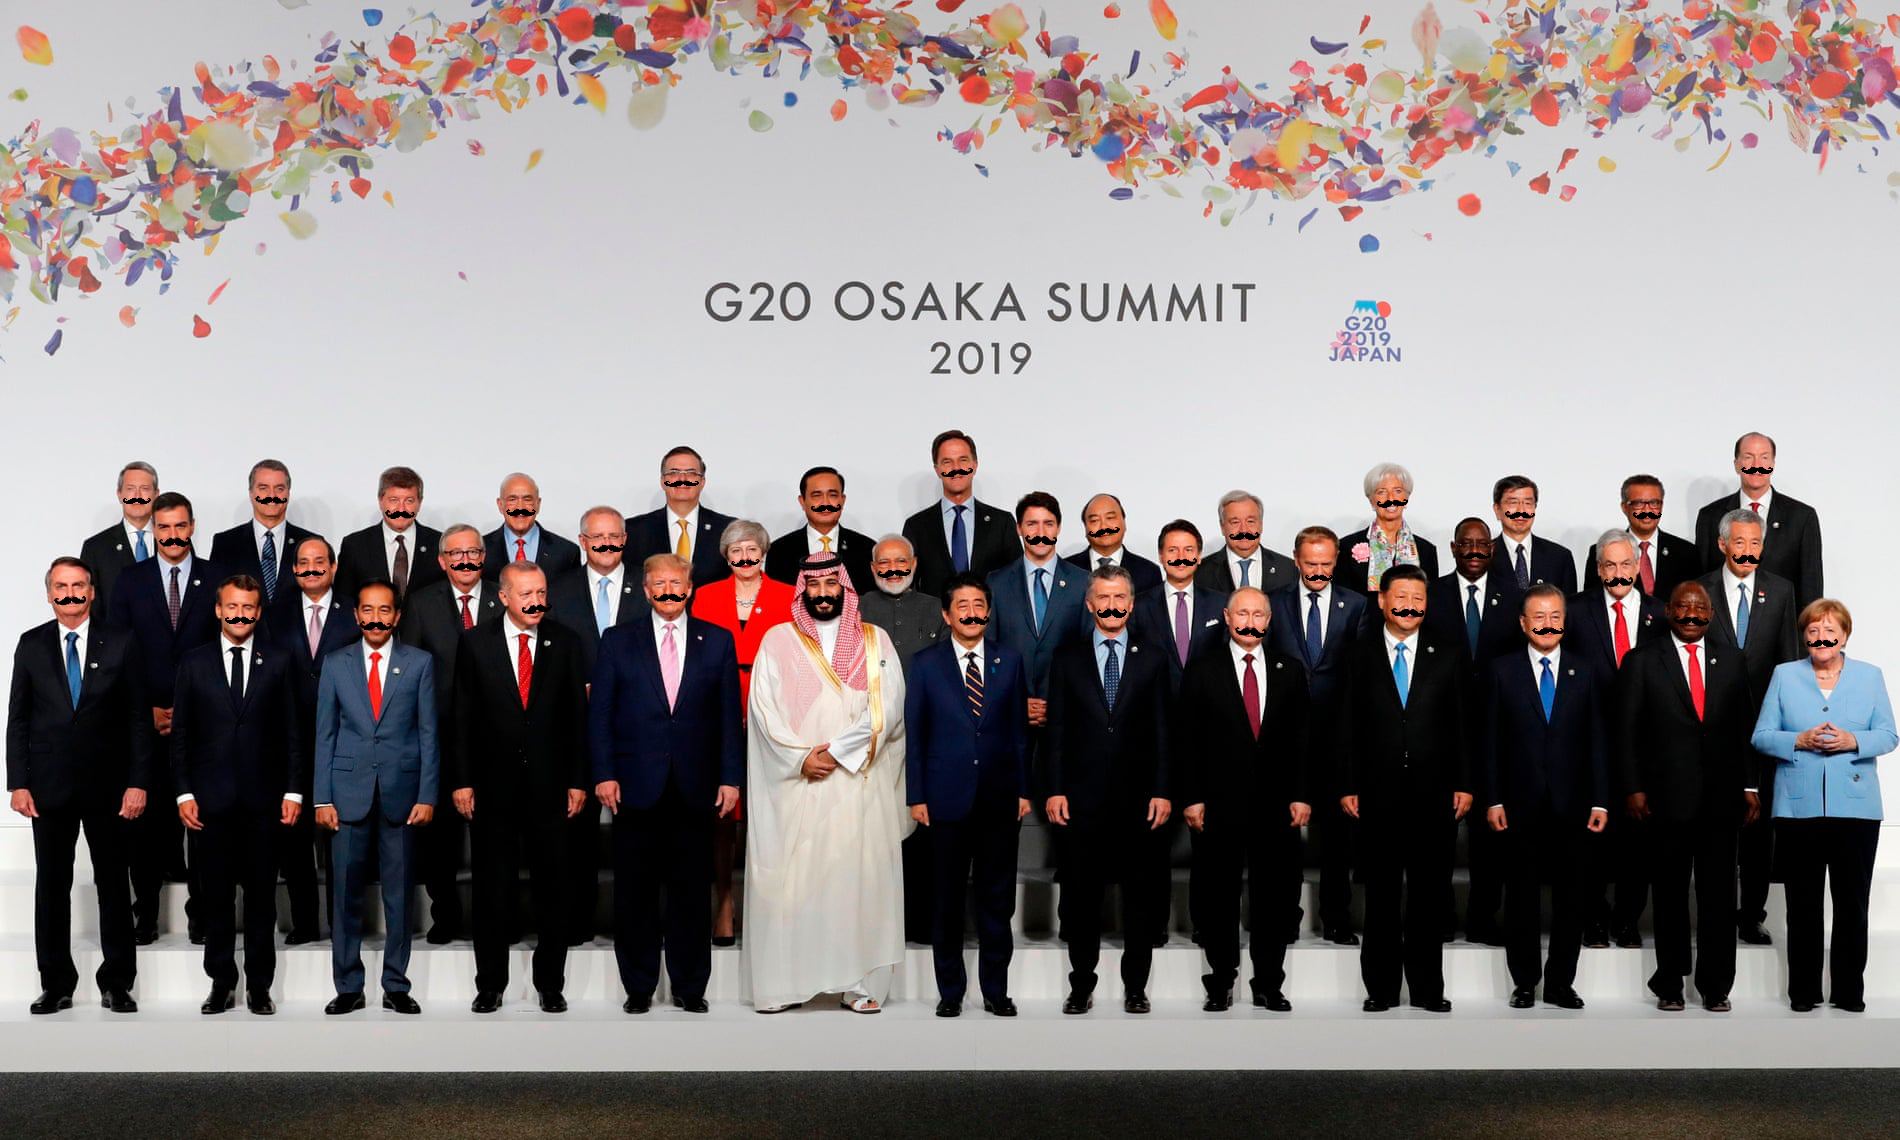

In [204]:
display(face)